In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error


import tensorflow as tf
keras = tf.keras
from datetime import datetime

ModuleNotFoundError: No module named 'matplotlib'

https://github.com/Morgan-Sell/caiso-price-forecast/blob/master/src/model.py

In [18]:
ROOT_PATH = 'Data_processed\\BZN-DE-LU\\'
data_2019 = pd.read_excel(ROOT_PATH+'Day_ahead_2019_DE_LU.xlsx')
data_2019.head()

,date,Hours,value
0,01/01/2019,00 - 01,10.07
1,01/01/2019,01 - 02,-4.08
2,01/01/2019,02 - 03,-9.91
3,01/01/2019,03 - 04,-7.41
4,01/01/2019,04 - 05,-12.55


In [19]:
def format_data(prices_raw_df):
    prices_raw_df['hour'] = prices_raw_df['Hours'].apply(lambda x: x[:2])
    prices_raw_df = prices_raw_df.drop('Hours', axis=1)
    prices_raw_df['time'] = pd.to_datetime(prices_raw_df['date']+prices_raw_df['hour'], format="%d/%m/%Y%H")
    prices_raw_df = prices_raw_df.set_index('time')
    return prices_raw_df['value']

In [20]:
prices_s = format_data(data_2019)

In [21]:
prices_s.describe()

count    8760.000000
mean       37.668148
std        15.517244
min       -90.010000
25%        31.060000
50%        38.065000
75%        46.270000
max       121.460000
Name: value, dtype: float64

In [22]:
#prices_s = prices_s.diff(1).dropna()

### ARIMA

In [138]:
# ARIMA MODEL
def arima_uni_var_train_valid_split(data, prop=0.2):
    """Slit train/test set"""
    split_idx = int((1-prop)*len(data))
    train_set = data[:split_idx]
    test_set = data[split_idx:]
    return train_set, test_set

def arima_uni_var_fit(train_set, p=24, d=1, q=0, seasonal_order=None):
    """
    Fits a univariate ARIMA model
    Parameters
    ----------
    train_set : arr
       Prices used to train ARIMA model.
    p : int
        The number of lag observations included in the model, commonly referred to as the lag order.
    d : int
        The number of times that the raw observations are differenced, commonly referred to as the degree of differencing.
    q : int
        The size of the moving average window.
    Returns
    -------
    ARIMA : object
        A fitted model to be used for predicting hourly electricity prices.
    """

    return ARIMA(endog=train_set, order=(p, d, q), freq='H', seasonal_order=seasonal_order).fit()

def arima_uni_var_predict(model, n_period_fcst):
    """
    Fits a univariate ARIMA model
    Parameters
    ----------
    model : object
       A fitted ARIMA model used to forecast hourly prices.
    n_period_fcst : int
        Number of hours to forecast
    Returns
    --------
    Prediction: arr
        An array of forecasted electricity prices
    """

    return model.forecast(steps=n_period_fcst)

In [121]:
train_set, test_set = arima_uni_var_train_valid_split(prices_s, prop=0.2)

In [122]:
model_arima = arima_uni_var_fit(train_set, p=24, d=1, q=0)

C:\Users\marti\anaconda3\envs\rhizome\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [123]:
n_forecast = 5
pred = arima_uni_var_predict(model_arima, n_forecast)

In [124]:
test_set[:6]

time
2019-10-20 00:00:00    27.01
2019-10-20 01:00:00    26.90
2019-10-20 02:00:00    26.51
2019-10-20 03:00:00    26.30
2019-10-20 04:00:00    27.03
2019-10-20 05:00:00    29.94
Name: value, dtype: float64

In [125]:
pred

2019-10-20 00:00:00    24.303646
2019-10-20 01:00:00    23.783609
2019-10-20 02:00:00    24.516124
2019-10-20 03:00:00    26.303150
2019-10-20 04:00:00    28.754261
Freq: H, Name: predicted_mean, dtype: float64

<AxesSubplot:xlabel='time'>

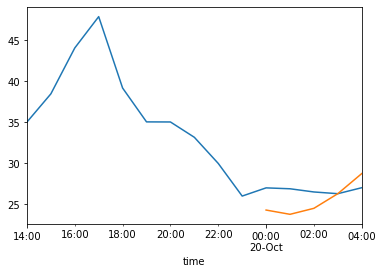

In [126]:
true = pd.concat([train_set.tail(10), test_set[:n_forecast]])
true.plot()
pred.plot()

## Run multi on multi weeks - n hours forecast

In [73]:
%%time
n_forecast = 24
n_curr_window = int(0.2*len(prices_s))
n_stop = 168
pred_list = []
for idx in range(n_stop):
    if idx % n_forecast == 0:
        model_arima = arima_uni_var_fit(prices_s[:n_curr_window], p=24, d=1, q=0)
        pred_list.append(arima_uni_var_predict(model_arima, n_forecast))
    n_curr_window +=1

C:\Users\marti\anaconda3\envs\rhizome\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\marti\anaconda3\envs\rhizome\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\marti\anaconda3\envs\rhizome\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\marti\anaconda3\envs\rhizome\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\marti\anaconda3\envs\rhizome\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency inform

CPU times: total: 4min 37s
Wall time: 34.8 s


In [74]:
pred_s = pd.concat(pred_list, axis=0)

#### Eval

In [75]:
n_curr_window = int(0.2*len(prices_s))
true_list = prices_s[n_curr_window:n_curr_window+n_stop]

In [76]:
assert len(true_list) == len(pred_s)

In [77]:
print(f"MAE : {mean_absolute_error(true_list, pred_s)} for {n_forecast} hours predicted over {n_stop/24/7} weeks")

MAE : 8.817211188184869 for 24 hours predicted over 1.0 weeks


In [78]:
pred_s.shape

(168,)

#### Plot

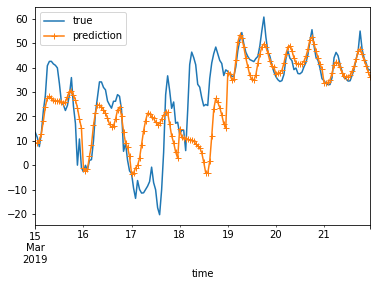

In [79]:
end_first_training = int(0.2*len(prices_s))

window_true = prices_s[end_first_training:end_first_training+n_stop]

window_true.plot(label='true')
pred_s.plot(label='prediction', marker='+')
#plt.scatter(window_pred.index[::5], window_pred.iloc[::5], marker='+', color='tab:red', s=100)
plt.legend()

* auto ARIMA
* conf interval
* less history data points

### Auto arima

<AxesSubplot:xlabel='time'>

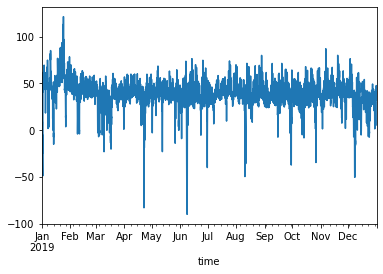

In [162]:
prices_s.plot()

### SARIMA

In [8]:
import pmdarima as pm

<AxesSubplot:xlabel='time'>

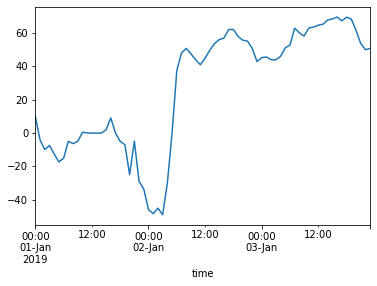

In [9]:
prices_s[:72].plot()

>The auto-ARIMA process seeks to identify the most optimal parameters for an ARIMA model, settling on a single fitted ARIMA model.
Auto-ARIMA works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto-ARIMA also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D

<AxesSubplot:xlabel='time'>

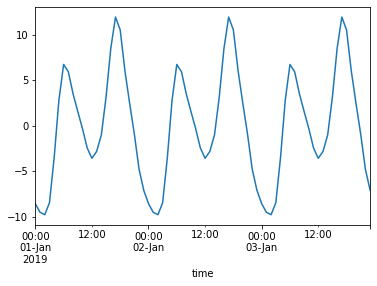

In [80]:
import statsmodels.api as sm
# one month
f = sm.tsa.seasonal_decompose(prices_s)
f.seasonal[:72].plot()

### Remove seasonal component

In [92]:
# create seasonally adjusted
prices_s_no_sea = prices_s - f.seasonal

* Remove trend

In [111]:
%%time
n_forecast = 24
n_curr_window = int(0.2*len(prices_s_no_sea))
n_stop = 168
pred_list = []
for idx in range(n_stop):
    if idx % n_forecast == 0:
        model_arima = arima_uni_var_fit(prices_s_no_sea[:n_curr_window], p=24, d=1, q=0)
        pred_list.append(arima_uni_var_predict(model_arima, n_forecast))
    n_curr_window +=1

C:\Users\marti\anaconda3\envs\rhizome\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\marti\anaconda3\envs\rhizome\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\marti\anaconda3\envs\rhizome\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\marti\anaconda3\envs\rhizome\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\marti\anaconda3\envs\rhizome\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency inform

CPU times: total: 2min 51s
Wall time: 21.5 s


In [112]:
pred_s = pd.concat(pred_list, axis=0)

n_curr_window = int(0.2*len(prices_s_no_sea))
true_list = prices_s[n_curr_window:n_curr_window+n_stop]

pred_s = pred_s + f.seasonal[end_first_training:end_first_training+n_stop]

mean_absolute_error(y_pred=pred_s, y_true=true_list)

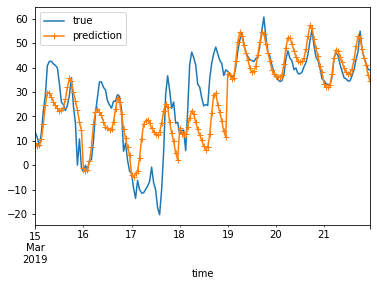

In [116]:
end_first_training = int(0.2*len(prices_s_no_sea))

window_true = prices_s[end_first_training:end_first_training+n_stop]
window_true.plot(label='true')
pred_s.plot(label='prediction', marker='+')
plt.legend()

In [141]:
train_set, test_set = arima_uni_var_train_valid_split(prices_s_no_sea, prop=0.2)

In [142]:
train_set.shape

(7008,)

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [143]:
%%time
start = len(train_set)-(7*24*10)
end = len(train_set)
model = pm.auto_arima(train_set[start:end], seasonal=True, m=24)

CPU times: total: 1h 3min 35s
Wall time: 7min 58s


In [144]:
model

ARIMA(order=(5, 0, 0), scoring_args={}, seasonal_order=(2, 0, 0, 24),
      suppress_warnings=True)

In [145]:
len(train_set)-(7*24*30)

1968

In [139]:
%%time
n_forecast = 24
n_curr_window = int(0.2*len(prices_s_no_sea))
n_stop = 168
pred_list = []
for idx in range(n_stop):
    if idx % n_forecast == 0:
        model_arima = arima_uni_var_fit(prices_s_no_sea[:n_curr_window], p=2, d=0, q=0, seasonal_order=(2, 0, 0, 24))
        pred_list.append(arima_uni_var_predict(model_arima, n_forecast))
    n_curr_window +=1 

C:\Users\marti\anaconda3\envs\rhizome\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\marti\anaconda3\envs\rhizome\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\marti\anaconda3\envs\rhizome\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\marti\anaconda3\envs\rhizome\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\marti\anaconda3\envs\rhizome\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency inform

CPU times: total: 9min 23s
Wall time: 1min 10s


In [140]:
pred_s = pd.concat(pred_list, axis=0)

n_curr_window = int(0.2*len(prices_s_no_sea))
true_list = prices_s[n_curr_window:n_curr_window+n_stop]

pred_s = pred_s + f.seasonal[end_first_training:end_first_training+n_stop]

mean_absolute_error(y_pred=pred_s, y_true=true_list)

8.343218784422055

### Baseline

In [156]:
test_set = prices_s.copy()
benchmark_results = pd.DataFrame(index=test_set.index)
benchmark_results['last_23h_hour'] = test_set.shift(23)
benchmark_results['last_day_hour'] = test_set.shift(24)
benchmark_results['last_week_day_hour'] = test_set.shift(24*7)
benchmark_results['last_5_days_kour_average'] = pd.concat([test_set.shift(24 * w) for w in range(1, 5)], axis=1).mean(axis=1)

In [157]:
benchmark_results = benchmark_results.iloc[n_curr_window:n_curr_window+n_stop]

In [158]:
for col in benchmark_results.columns:
    #pred = benchmark_results[col].as_matrix()
    print('MAE of {} benchmark model: '.format(col), mean_absolute_error(y_pred=benchmark_results[col], y_true=true_list))

MAE of last_23h_hour benchmark model:  13.302559523809524
MAE of last_day_hour benchmark model:  12.810595238095237
MAE of last_week_day_hour benchmark model:  13.90154761904762
MAE of last_5_days_kour_average benchmark model:  16.063020833333333


### Comparaison with LSTM

In [159]:
from keras.models import Model, load_model
from keras.layers import Input, Add
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv1D
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2
from keras import optimizers

In [161]:
model_lstm = keras.models.load_model('lstm_poc_v0')

* need to scale
* need to lag

In [ ]:
%%time
n_forecast = 24
n_curr_window = int(0.2*len(prices_s_no_sea))
n_stop = 168
pred_list = []
for idx in range(n_stop):
    if idx % n_forecast == 0:
        model_arima = arima_uni_var_fit(prices_s_no_sea[:n_curr_window], p=2, d=0, q=0, seasonal_order=(2, 0, 0, 24))
        pred_list.append(arima_uni_var_predict(model_arima, n_forecast))
    n_curr_window +=1 